# Práctico 3: Validación cruzada y Regularización

## Objetivos del trabajo

* Objetivo general:
    - Introducir las técnicas de validación cruzada y regularización
* Objetivos específicos:
    - Continuar el estudio del dataset de la ECH, en este caso con una variable de respuesta continua
    - Aplicar herramientas de análisis estadístico descriptivo adecuadas al caso
    - Aplicar las técnicas de validación cruzada y regularización


## Presentación del caso de estudio

* Predicción del ingreso de las personas:
    - Queremos desarrollar un modelo de predicción de los ingresos de las personas por trabajo en relación de dependencia, a partir de los datos de la ECH
1. Objetivo:
    * **Tarea (T)**: predicción del ingreso de las personas por su trabajo en relación de dependencia, a partir de los datos de la ECH.
    * **Entrenamiento (E)**: utilizamos los datos de la Encuesta Continua de Hogares del INE (ECH) de 2017.
    * **Performance (P)**: buscamos minimizar el error de predicción definido como MSE (error cuadrático medio).
2. Links de referencia:
    * [Encuesta Continua de Hogares 2017](https://anterior.ine.gub.uy/web/guest/encuesta-continua-de-hogares1)
    * Datos a utilizar: [Bases ECH 2017 en formato sav](https://anterior.ine.gub.uy/c/document_library/get_file?uuid=e38ea53c-7253-4007-9f67-2f5f161eea91&groupId=10181)
    * [Diccionario de variables ECH 2017](https://anterior.ine.gub.uy/c/document_library/get_file?uuid=b60f247b-03cb-4bb1-b84b-5d7328479fe2&groupId=10181)
3. Entendimiento del caso:
    * Lectura de la documentación de los datos de la ECH
    * Análisis del diccionario de datos de la ECH
    * ¿Cuál es la variable objetivo *Y*?
    * Planteo inicial de hipótesis: Definición del enfoque de uso de variables (no existe receta)
        - De menos a más: variable por variable, probando una hipótesis a la vez, utilizando combinaciones
        - Usar todas las variables de una vez

## Setup

* Importación de las librerías

In [49]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, LinearRegression

* Seteo de directorio de trabajo

In [2]:
os.chdir(os.getcwd())

## Importación de los datos

In [3]:
dfP2017 = pd.read_spss(r'data/Base ECH 2017 formato SAV/P_2017_Terceros.sav')
dfP2017.describe()

,nper,ccz,barrio,pesoano,pesosem,pesotri,pesomen,e558,e27,e34,...,indaceliac,indatuberc,indaoncolo,indasida,indaucc,PT1,PT2,PT4,pobre06,indigente06
count,118268.000000,118268.00000,118268.000000,118268.000000,118268.000000,118268.000000,118268.000000,118268.000000,118268.000000,118268.000000,...,118268.000000,118268.000000,118268.000000,118268.000000,118268.000000,1.182680e+05,1.182680e+05,1.182680e+05,118268.000000,118268.000000
mean,2.207749,3.37552,10.910686,29.535758,29.536223,118.142025,354.403609,0.888896,38.736387,0.687802,...,674.948228,584.551409,576.391526,576.391526,647.470634,1.969790e+04,1.352395e+04,1.445637e+04,0.071575,0.001268
std,1.343722,5.23772,17.895304,6.263963,30.514906,27.249899,90.123013,2.182706,23.577532,0.899283,...,32.140374,31.997071,11.919400,11.919400,43.427110,3.000104e+04,2.695283e+04,2.885611e+04,0.257784,0.035591
min,1.000000,0.00000,0.000000,10.000000,0.000000,20.000000,52.000000,0.000000,0.000000,0.000000,...,579.000000,550.000000,550.000000,550.000000,545.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.000000,0.00000,0.000000,25.000000,0.000000,100.000000,295.000000,0.000000,18.000000,0.000000,...,663.000000,578.000000,578.000000,578.000000,662.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,2.000000,0.00000,0.000000,30.000000,29.000000,120.000000,356.000000,1.000000,38.000000,0.000000,...,689.000000,580.000000,580.000000,580.000000,665.000000,1.200950e+04,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,3.000000,6.00000,18.000000,34.000000,60.000000,137.000000,414.000000,1.000000,57.000000,1.000000,...,693.000000,585.000000,585.000000,585.000000,672.000000,2.800000e+04,2.183600e+04,2.205600e+04,0.000000,0.000000
max,15.000000,18.00000,62.000000,50.000000,101.000000,228.000000,738.000000,90.000000,98.000000,10.000000,...,698.000000,683.000000,586.000000,586.000000,683.000000,2.801935e+06,2.801935e+06,2.801935e+06,1.000000,1.000000


## Preparación de los datos

In [4]:
df_ysos = pd.DataFrame()

df_ysos['ysos_dep'] = dfP2017['g126_1'] + dfP2017['g126_2'] + dfP2017['g126_3'] \
    + dfP2017['g126_4'] + dfP2017['g134_1'] + dfP2017['g134_2'] \
    + dfP2017['g134_3'] + dfP2017['g134_4']

df_ysos['edad'] = dfP2017['e27']
df_ysos['sexo'] = dfP2017['e26']
df_ysos['antiguedad'] = dfP2017['f88_2']
df_ysos['categoria_ocup'] = dfP2017['f73']
df_ysos['anios_educ'] = dfP2017['e51_2'] + dfP2017['e51_3'] + dfP2017['e51_4'] \
    + dfP2017['e51_5'] + dfP2017['e51_6'] + dfP2017['e51_7'] + dfP2017['e51_8'] \
    + dfP2017['e51_9'] + dfP2017['e51_10'] + dfP2017['e51_11']

df_ysos = df_ysos[df_ysos['ysos_dep'] > 0]
df_ysos = df_ysos.loc[(df_ysos['categoria_ocup'] == "Asalariado/a privado/a") | (df_ysos['categoria_ocup'] == "Asalariado/a público/a")]

In [5]:
df_ysos['l_ysos_dep'] = np.log(df_ysos['ysos_dep'])
df_l_ysos = df_ysos.drop(columns=['ysos_dep'])
df_l_ysos.head()

,edad,sexo,antiguedad,categoria_ocup,anios_educ,l_ysos_dep
0,70.0,Hombre,7.0,Asalariado/a privado/a,6.0,9.798127
2,52.0,Hombre,32.0,Asalariado/a público/a,6.0,10.778956
5,42.0,Mujer,0.0,Asalariado/a privado/a,16.0,10.404263
7,29.0,Mujer,1.0,Asalariado/a privado/a,8.0,7.783224
8,37.0,Hombre,4.0,Asalariado/a privado/a,6.0,10.043249


In [6]:
categorical_columns = ['sexo', 'categoria_ocup']
numerical_columns = ['edad', 'anios_educ', 'antiguedad']

column_transform = make_column_transformer(
    (StandardScaler(), numerical_columns),
    (OneHotEncoder(drop='if_binary'), categorical_columns),
    remainder='passthrough',
    verbose_feature_names_out=False)

df_l_ysos_transf = pd.DataFrame(
    column_transform.fit_transform(df_l_ysos), 
    columns=column_transform.get_feature_names_out()
)
df_l_ysos_transf.head()

,edad,anios_educ,antiguedad,sexo_Mujer,categoria_ocup_Asalariado/a público/a,l_ysos_dep
0,2.291690,-1.207866,-0.164103,0.0,0.0,9.798127
1,0.896131,-1.207866,2.438510,0.0,1.0,10.778956
2,0.120821,0.966088,-0.892834,1.0,0.0,10.404263
3,-0.887083,-0.773075,-0.788730,1.0,0.0,7.783224
4,-0.266835,-1.207866,-0.476416,0.0,0.0,10.043249


## División del dataset en Train y Test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df_l_ysos_transf[['edad', 'sexo_Mujer', 'anios_educ', 'antiguedad', 'categoria_ocup_Asalariado/a público/a']],
    df_l_ysos_transf['l_ysos_dep'], 
    test_size=0.20, 
    random_state=1234
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29908, 5), (7477, 5), (29908,), (7477,))

## Generación del Pipeline

**¿Qué es un _pipeline_ en _machine learning_?**

Los _pipelines_ de datos se caracterizan por definir el conjunto de pasos o fases y las tecnologías involucradas en un proceso de movimiento o procesamiento de datos.

In [8]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(X_train, y_train)

y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

print(f'Model Error Train: {mean_squared_error(y_train, y_train_pred)}')
print(f'Model Error Test: {mean_squared_error(y_test, y_test_pred)}')

Model Error Train: 0.3702760646178663
Model Error Test: 0.3736517352939237


## Validación cruzada

- Información de la función [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

- Información de [scoring](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [9]:
k_folds = 10

scores_cv = cross_val_score(pipeline, X = X_train, y = y_train, cv = k_folds, scoring='neg_mean_squared_error')
print('CV Error for a %s folds: \n%s' %(k_folds, -1*scores_cv))

CV Error for a 10 folds: 
[0.36184985 0.34843655 0.37479687 0.36835287 0.37265196 0.3570935
 0.39058732 0.36250988 0.36535322 0.40296933]


In [10]:
error_train = mean_squared_error(y_train, y_train_pred)
error_cv = -1 * np.mean(scores_cv)
error_test = mean_squared_error(y_test, y_test_pred)

print(f'Model Error Train: {error_train}')
print(f'Model Error Test: {error_test}')
print(f'Model Error CV: {error_cv} ± {np.std(scores_cv)}')

Model Error Train: 0.3702760646178663
Model Error Test: 0.3736517352939237
Model Error CV: 0.3704601334360113 ± 0.015222130830402362


**Tarea 2.6:** Incorporar más variables. Analizar los resultados para CV y conclusiones

Para esta tarea, entonces, se pide agregar más variables del dataset original y
repetir lo realizado en celdas anteriores, para lograr comparar el error
obtenido en el proceso de _cross validation_. Para ello:

In [11]:
df_additional_columns = df_l_ysos.copy()
columns_to_add = ['mto_cuota', 'mto_emer', 'mto_hogcon', 'mto_desay',
                'mto_almue', 'mto_vacas', 'mto_oveja', 'mto_caball', 
                'indabajo', 'indaplomo', 'indadiabet', 'indarenal',
                'indarendia', 'indaceliac', 'pesoano', 'pesosem', 'pesotri',
                'pesomen', 'indatuberc', 'indaoncolo', 'indasida']

for column in columns_to_add:
    df_additional_columns[column] = dfP2017[column]

additional_column_transform = make_column_transformer(
    (StandardScaler(), numerical_columns + columns_to_add),
    (OneHotEncoder(drop='if_binary'), categorical_columns),
    remainder='passthrough',
    verbose_feature_names_out=False)

df_additional_columns_t = pd.DataFrame(
    additional_column_transform.fit_transform(df_additional_columns), 
    columns=additional_column_transform.get_feature_names_out()
)
df_additional_columns_t.head()

,edad,anios_educ,antiguedad,mto_cuota,mto_emer,mto_hogcon,mto_desay,mto_almue,mto_vacas,mto_oveja,...,pesoano,pesosem,pesotri,pesomen,indatuberc,indaoncolo,indasida,sexo_Mujer,categoria_ocup_Asalariado/a público/a,l_ysos_dep
0,2.291690,-1.207866,-0.164103,-1.638654,0.774950,-3.245221,-3.245221,-3.245221,-0.088074,-0.709761,...,-0.221032,0.919763,-0.061062,-0.282238,0.005259,0.721739,0.721739,0.0,0.0,9.798127
1,0.896131,-1.207866,2.438510,-0.721851,-0.883782,0.308145,0.308145,0.308145,-1.050833,-0.709761,...,0.585064,1.238923,0.577820,1.174103,-0.210475,0.135379,0.135379,0.0,1.0,10.778956
2,0.120821,0.966088,-0.892834,-1.043536,0.965296,0.308145,0.308145,0.308145,-1.050833,-0.709761,...,-0.704690,0.664434,-0.775106,-0.722527,0.005259,0.721739,0.721739,1.0,0.0,10.404263
3,-0.887083,-0.773075,-0.788730,-0.947031,0.974360,0.308145,0.308145,0.308145,-1.050833,-0.709761,...,1.229940,1.462336,1.179120,0.970893,-0.148836,0.302910,0.302910,1.0,0.0,7.783224
4,-0.266835,-1.207866,-0.476416,-0.947031,0.974360,0.308145,0.308145,0.308145,-1.050833,-0.709761,...,1.229940,1.462336,1.179120,0.970893,-0.148836,0.302910,0.302910,0.0,0.0,10.043249


In [12]:
X_train_a, X_test_a, y_train_a, y_test_a =  train_test_split(
    df_additional_columns_t.drop('l_ysos_dep', axis=1),
    df_additional_columns_t['l_ysos_dep'], 
    test_size=0.20, 
    random_state=1234
)

X_train_a.shape, X_test_a.shape, y_train_a.shape, y_test_a.shape

((29908, 26), (7477, 26), (29908,), (7477,))

In [31]:
k_folds = 10

pipeline.fit(X_train_a, y_train_a)
scores_cv_a = cross_val_score(pipeline, X = X_train_a, y = y_train_a, cv = k_folds, scoring='neg_mean_squared_error')
print('CV Error for a %s folds: \n%s\n' %(k_folds, -1 * scores_cv_a))

error_train_a = mean_squared_error(y_train_a, pipeline.predict(X_train_a))
error_test_a = mean_squared_error(y_test_a, pipeline.predict(X_test_a))
error_cv_a = -1 * np.mean(scores_cv_a)

print(f'Model Error Train: {error_train_a}')
print(f'Model Error Test: {error_test_a}')
print(f'Model Error CV: {error_cv_a} ± {np.std(scores_cv_a)}')

CV Error for a 10 folds: 
[0.35454656 0.34449619 0.36903326 0.36311118 0.36751582 0.35343479
 0.38298373 0.35626569 0.35674611 0.39719864]

Model Error Train: 0.36398525086559286
Model Error Test: 0.3692238964005467
Model Error CV: 0.3645331957817406 ± 0.014805409327388701


En cuanto a los resultados/errores obtenidos luego de incorporar estas nuevas columnas,
y en particular con respecto a (como pide la propuesta), el valor calculado para
el error de _cross validation_, podemos observar que este ha disminuido
levemente en cuanto su valor medio, si bien esta disminución es menor a la
desviación estándar para el mismo.

Esto puede indicar que las columnas agregadas tal cual podrían no ser valiosas
como variables predictoras de la variable objetivo en este caso, pudiéndose
entonces considerar agregar otras o alguna transformación de datos adicional que
pueda resultar más beneficiosa de acuerdo al modelo de _machine learning_
seleccionado y a las características concretas del problema.

## Realizamos implementación de CV con varias fórmulas (sesgos inductivos)

* Aprovechamos salida de `sm.OLS`, por lo que agregamos una constante al _dataset_ de _train_
* Luego debemos descartar (o no incluir) la constante en el _dataset_ de _train_ al utilizar la función `cross_validate`
* [Por qué `neg_mean_squared_error`](https://stackoverflow.com/questions/48244219/is-sklearn-metrics-mean-squared-error-the-larger-the-better-negated)

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

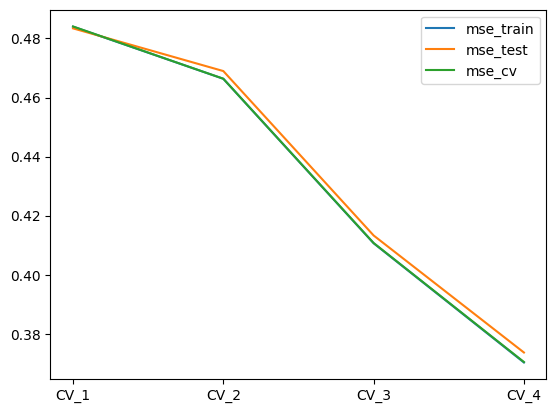

In [15]:
model = LinearRegression()

independent_1 = ['anios_educ']
independent_2 = ['antiguedad']
independent_3 = ['edad', 'sexo_Mujer', 'anios_educ']
independent_4 = ['edad', 'sexo_Mujer', 'anios_educ', 'antiguedad', 'categoria_ocup_Asalariado/a público/a']

CV_1_X_train = sm.add_constant(X_train[independent_1])
CV_2_X_train = sm.add_constant(X_train[independent_2])
CV_3_X_train = sm.add_constant(X_train[independent_3])
CV_4_X_train = sm.add_constant(X_train[independent_4])

CV_1_X_test = sm.add_constant(X_test[independent_1])
CV_2_X_test = sm.add_constant(X_test[independent_2])
CV_3_X_test = sm.add_constant(X_test[independent_3])
CV_4_X_test = sm.add_constant(X_test[independent_4])

modCV_1 = sm.OLS(y_train, CV_1_X_train).fit()
modCV_2 = sm.OLS(y_train, CV_2_X_train).fit()
modCV_3 = sm.OLS(y_train, CV_3_X_train).fit()
modCV_4 = sm.OLS(y_train, CV_4_X_train).fit()

CV_1_y_train_pred = modCV_1.predict(CV_1_X_train)
CV_2_y_train_pred = modCV_2.predict(CV_2_X_train)
CV_3_y_train_pred = modCV_3.predict(CV_3_X_train)
CV_4_y_train_pred = modCV_4.predict(CV_4_X_train)

CV_1_y_test_pred = modCV_1.predict(CV_1_X_test)
CV_2_y_test_pred = modCV_2.predict(CV_2_X_test)
CV_3_y_test_pred = modCV_3.predict(CV_3_X_test)
CV_4_y_test_pred = modCV_4.predict(CV_4_X_test)

CV_1_mse_train = mean_squared_error(y_train, CV_1_y_train_pred)
CV_2_mse_train = mean_squared_error(y_train, CV_2_y_train_pred)
CV_3_mse_train = mean_squared_error(y_train, CV_3_y_train_pred)
CV_4_mse_train = mean_squared_error(y_train, CV_4_y_train_pred)

CV_1_mse_test = mean_squared_error(y_test, CV_1_y_test_pred)
CV_2_mse_test = mean_squared_error(y_test, CV_2_y_test_pred)
CV_3_mse_test = mean_squared_error(y_test, CV_3_y_test_pred)
CV_4_mse_test = mean_squared_error(y_test, CV_4_y_test_pred)

CV_1_mse_cv = -cross_validate(model, X_train[independent_1], y_train, cv=5, scoring=('neg_mean_squared_error'))['test_score'].mean()
CV_2_mse_cv = -cross_validate(model, X_train[independent_2], y_train, cv=5, scoring=('neg_mean_squared_error'))['test_score'].mean()
CV_3_mse_cv = -cross_validate(model, X_train[independent_3], y_train, cv=5, scoring=('neg_mean_squared_error'))['test_score'].mean()
CV_4_mse_cv = -cross_validate(model, X_train[independent_4], y_train, cv=5, scoring=('neg_mean_squared_error'))['test_score'].mean()

evaluate = pd.DataFrame(            
    {'mod': pd.Series(['CV_1', 'CV_2', 'CV_3', 'CV_4']).astype('category'),
     'mse_train': pd.Series([CV_1_mse_train, CV_2_mse_train, CV_3_mse_train, CV_4_mse_train]).astype('float64'),
     'mse_test': pd.Series([CV_1_mse_test, CV_2_mse_test, CV_3_mse_test, CV_4_mse_test]).astype('float64'),
     'mse_cv': pd.Series([CV_1_mse_cv, CV_2_mse_cv, CV_3_mse_cv, CV_4_mse_cv]).astype('float64')    
    }
)

plt.plot(evaluate['mod'], evaluate['mse_train'], label = 'mse_train')
plt.plot(evaluate['mod'], evaluate['mse_test'], label = 'mse_test')
plt.plot(evaluate['mod'], evaluate['mse_cv'], label = 'mse_cv')
plt.legend(loc="upper right")

In [16]:
evaluate

,mod,mse_train,mse_test,mse_cv
0,CV_1,0.484009,0.483428,0.484063
1,CV_2,0.466348,0.468965,0.466375
2,CV_3,0.410643,0.413290,0.410748
3,CV_4,0.370276,0.373652,0.370442


## Regularización

- [Información de la función `linear_model.Lasso()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

- [Información de la función `linear_model.Ridge()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

- Utilizamos todas las variables independientes

In [35]:
lasso = Lasso()
scores_cv_lasso = cross_val_score(lasso, X = X_train, y = y_train, cv = k_folds, scoring='neg_mean_squared_error')

print(f'CV error for a {k_folds} folds:\n{-1 * scores_cv}\n')
print(f'CV error for a {k_folds} folds and Lasso:\n{-1 * scores_cv_lasso}\n')

print(f'Model Score CV and Lasso: {-1*np.mean(scores_cv_lasso)} ± {np.std(scores_cv_lasso)}')

CV error for a 10 folds:
[0.36184985 0.34843655 0.37479687 0.36835287 0.37265196 0.3570935
 0.39058732 0.36250988 0.36535322 0.40296933]

CV error for a 10 folds and Lasso:
[0.54047742 0.51983601 0.54680093 0.54502584 0.56659792 0.53170517
 0.58762435 0.5532353  0.57257552 0.57738057]

Model Score CV and Lasso: 0.5541259025636237 ± 0.02039826452296217


In [30]:
pd.DataFrame({
    "Error Train": [error_train],
    "Error CV": [error_cv],
    "Error CV Lasso": [-1 * np.mean(scores_cv_lasso)],
    "Error Test": [error_test],
})

,Error Train,Error CV,Error CV Lasso,Error Test
0,0.370276,0.37046,0.554126,0.373652


**Tarea 2.7:** Incorporar más variables y aplicar la regularización utilizando
`Ridge` y `Lasso`, y comparar los resultados. ¿Qué conclusiones puede obtener?

Recurriendo el _dataset_ con variables adicionales utilizado para partes
anteriores, y aplicando el procedimiento anterior para los algoritmos de
regularización mencionados, se obtiene:

**Lasso:**

In [39]:
lasso_a = Lasso()
scores_cv_lasso_a = cross_val_score(lasso_a, X = X_train_a, y = y_train_a, cv = k_folds, scoring='neg_mean_squared_error')

print(f'CV error for a {k_folds} folds:\n{-1 * scores_cv_a}\n')
print(f'CV error for a {k_folds} folds and Lasso:\n{-1 * scores_cv_lasso_a}\n')

print(f'Model Score CV and Lasso: {-1*np.mean(scores_cv_lasso_a)} ± {np.std(scores_cv_lasso_a)}')

CV error for a 10 folds:
[0.35454656 0.34449619 0.36903326 0.36311118 0.36751582 0.35343479
 0.38298373 0.35626569 0.35674611 0.39719864]

CV error for a 10 folds and Lasso:
[0.54047742 0.51983601 0.54680093 0.54502584 0.56659792 0.53170517
 0.58762435 0.5532353  0.57257552 0.57738057]

Model Score CV and Lasso: 0.5541259025636237 ± 0.02039826452296217


**Ridge:**

In [40]:
ridge_a = Ridge()
scores_cv_ridge_a = cross_val_score(ridge_a, X = X_train_a, y = y_train_a, cv = k_folds, scoring='neg_mean_squared_error')

print(f'CV error for a {k_folds} folds:\n{-1 * scores_cv_a}\n')
print(f'CV error for a {k_folds} folds and Lasso:\n{-1 * scores_cv_ridge_a}\n')

print(f'Model Score CV and Lasso: {-1*np.mean(scores_cv_ridge_a)} ± {np.std(scores_cv_ridge_a)}')

CV error for a 10 folds:
[0.35454656 0.34449619 0.36903326 0.36311118 0.36751582 0.35343479
 0.38298373 0.35626569 0.35674611 0.39719864]

CV error for a 10 folds and Lasso:
[0.35453652 0.34449719 0.36903281 0.36301248 0.36751883 0.35343284
 0.38297715 0.35623734 0.35675518 0.39718142]

Model Score CV and Lasso: 0.3645181758219463 ± 0.014803608365999674


In [41]:
pd.DataFrame({
    "Error Train": [error_train_a],
    "Error CV": [error_cv_a],
    "Error CV Lasso": [-1 * np.mean(scores_cv_lasso_a)],
    "Error CV Ridge": [-1 * np.mean(scores_cv_ridge_a)],
    "Error Test": [error_test_a],
})

,Error Train,Error CV,Error CV Lasso,Error CV Ridge,Error Test
0,0.363985,0.364533,0.554126,0.364518,0.369224


En cuanto a los resultados obtenidos es posible observar que el error de
_cross validation_ aumenta para la utilización de `Lasso`, y disminuye, si bien
de manera apenas apreciable, para la utilización de `Ridge`. Esto puede indicar,
aunque en este caso dados los valores obtenidos no parece muy probable (puesto
que los errores de _train_ y _test_ son bastante cercanos),que el modelo
original sufriera de sobreajuste, y por tanto poder ser positivo el uso de
técnicas de regularización para contrarrestar esto.

Por otro lado, el que el uso de `Ridge` fuera el que trajo esa mejora, puede
indicar que, dentro de las variables seleccionadas, no resulta un factor decisivo
en la performance del modelo un subconjunto de variables predictoras con alta
correlación, sino la relación entre ellas en conjunto como forma de dar el valor
de la variable objetivo. Dado que `Lasso` penaliza individualmente las variables,
tendiendo a 0 las _features_ menos valiosas, mientras que `Ridge` lo hace 
reduciendo o limitando los pesos de todas ellas en general, esta situación
podría explicar los resultados dispares obtenidos al aplicar estas dos técnicas.

### Determinación de coeficiente de regularización con CV

* Mejor coeficiente de regularización (en _cross validation_)

In [45]:
mod_lassoCV = LassoCV().fit(X_train, y_train)
mod_lassoCV.alpha_

0.0002966004675454342

* Ajuste del modelo con regularización, con el mejor coeficiente

In [46]:
las = Lasso(alpha=mod_lassoCV.alpha_)
mod_lasso = las.fit(X_train, y_train)
mse_lasso = cross_val_score(las, X_train, y_train, scoring="neg_mean_squared_error")
np.abs(np.mean(mse_lasso))

0.37044343250528555

* Observamos coeficientes (beta)

In [47]:
print(mod_lasso.coef_)
print(mod_lasso.intercept_)

[ 0.06970953 -0.37775463  0.27575222  0.2115702   0.13531883]
10.119057125017573


* MSE en _Test_

In [48]:
mod_lasso_y_test_pred = mod_lasso.predict(X_test)
mean_squared_error(y_test, mod_lasso_y_test_pred)

0.3736611409978439

**Tarea 2.8:** ¿Qué conclusiones obtiene? ¿Se cumple la selección de variables al aplicar Lasso? Agregar más variables y comentar los resultados

Nuevamente, recurriendo a la variante del _dataset_ con variables adicionales
utilizada en las partes anteriores, los resultados obtenidos serían:

**Lasso:**

In [66]:
mod_lassoCV_a = LassoCV().fit(X_train_a, y_train_a)
mod_lassoCV_a.alpha_

0.0005959394479685095

In [67]:
las_a = Lasso(alpha=mod_lassoCV_a.alpha_)
mod_lasso_a = las_a.fit(X_train_a, y_train_a)
mse_lasso_a = cross_val_score(las_a, X_train_a, y_train_a, scoring="neg_mean_squared_error")

print(f'CV MSE Lasso Additional: {np.abs(np.mean(mse_lasso_a))}')
print(f'Coefficients: {mod_lasso_a.coef_}')
print(f'Intercept: {mod_lasso_a.intercept_}')
print(f'Error Test: {mean_squared_error(y_test_a, mod_lasso_a.predict(X_test_a))}')

CV MSE Lasso Additional: 0.3644546617949095
Coefficients: [ 6.31282245e-02  2.52647969e-01  2.09528745e-01  0.00000000e+00
  8.13196301e-02 -3.64420785e-03 -3.81667496e-18 -3.45886168e-18
 -9.38500046e-03  1.38739091e-02  1.07686522e-02  8.86850954e-03
  4.41380135e-18  0.00000000e+00 -1.16266268e-04 -1.31616976e-18
 -4.18781287e-18 -0.00000000e+00 -1.73868042e-03 -6.75748398e-03
 -2.82444541e-03 -3.22417309e-04  0.00000000e+00  0.00000000e+00
 -3.81097771e-01  1.48088698e-01]
Intercept: 10.118065493559948
Error Test: 0.36916222303401175


En cuanto a los resultados que la aplicación de este proceso arroja en comparación
con secciones anteriores, parecería ser que la utilización de este valor óprimo de
`alpha`, obtenido mediante _cross validation_, como parámetro de regularización
en `Lasso`, resulta en una mejor _performance_ del modelo. Concretamente, utilizándose
tal valor el error en _test_ se reduce respecto al valor por defecto de este parámetro,
lo cual es una métrica deseable.<br>
Asimismo, en cuanto al funcionamiento de `Lasso` en sí, al imprimirse los coeficientes
podemos observar algunos valores en 0, característica de esta técnica de regularización
(tendencia a establecer en 0 coeficientes de _features_ con menor valor, conocida como
_feature selection_).


**Tarea 2.9:** Ídem 2.8, pero utilizando Ridge

Repitiendo el procedimiento realizado en las celdas superiores para el método de
regularización de `Ridge`, se obtiene que:

**Ridge:**

In [72]:
mod_ridgeCV_a = RidgeCV().fit(X_train_a, y_train_a)
mod_ridgeCV_a.alpha_

10.0

In [71]:
rid_a = Ridge(alpha=mod_ridgeCV_a.alpha_)
mod_ridge_a = rid_a.fit(X_train_a, y_train_a)
mse_ridge_a = cross_val_score(rid_a, X_train_a, y_train_a, scoring="neg_mean_squared_error")

print(f'CV MSE Ridge Additional: {np.abs(np.mean(mse_ridge_a))}')
print(f'Coefficients: {mod_ridge_a.coef_}')
print(f'Intercept: {mod_ridge_a.intercept_}')
print(f'Error Test: {mean_squared_error(y_test_a, mod_ridge_a.predict(X_test_a))}')

CV MSE Ridge Additional: 0.3644938247013527
Coefficients: [ 6.37283952e-02  2.53028615e-01  2.09079805e-01 -1.60872786e-04
  8.19981798e-02 -2.08482315e-03 -2.08482315e-03 -2.08482315e-03
 -1.72397527e-02  2.21323123e-02  1.04922081e-02 -1.22985606e-03
 -1.22985606e-03  1.56695319e-02 -9.87349903e-04 -9.87349903e-04
 -9.87349903e-04  1.62510789e-03 -5.82655504e-03 -8.08153999e-03
 -2.91801163e-03  1.20341011e-03 -9.62443122e-05 -9.62443122e-05
 -3.83627719e-01  1.51475086e-01]
Intercept: 10.118581899368564
Error Test: 0.369221883168054


En el caso de `Ridge`, también, se cumplen las observaciones realizadas para el
anterior; concretamente, que a través de la utilización del parámetro `alpha`
calculado se ha obtenido un modelo con mejor _performance_, entendida como
menores valores en el error de _cross validation_ y, particularmente
el error de _test_. En cuanto a los coeficientes hallados, también, se observa
que ninguno adopta el valor 0, característica que es consistente con el
comportamiento esperado para la técnica de regularización `Ridge`.